In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path
from matchms import calculate_scores, Spectrum
from dreams.definitions import MONA_PKL, MONA, NIST20_PKL, NIST20
from dreams.models.dreams.dreams import get_embeddings
from dreams.utils.dreams import get_dreams_embeddings
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.functional import pairwise_cosine_similarity
from matchms.similarity import ModifiedCosine, CosineGreedy
import dreams.utils.mols as mu
import dreams.utils.spectra as su
from dreams.definitions import *
%load_ext autoreload
%autoreload 2

/Users/roman/miniconda/envs/msml39/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
df = pd.read_pickle(NIST20 / 'nist20_clean_A.pkl')

In [3]:
common_adducts = ['[M+H]+', '[M+Na]+', '[2M+H]+']
df_common_adducts = df[df['PRECURSOR TYPE'].isin(common_adducts)]
df_common_adducts_gb = df_common_adducts.groupby('NAME').agg({'PRECURSOR TYPE': 'nunique'})
df_common_adducts_gb = df_common_adducts_gb[df_common_adducts_gb['PRECURSOR TYPE'] == len(common_adducts)]
df_common_adducts = df_common_adducts[df_common_adducts['NAME'].isin(df_common_adducts_gb.index.tolist())]
df_common_adducts = df_common_adducts.reset_index()
print(df_common_adducts['NAME'].nunique())
df_common_adducts

329


,index,NAME,NOTES,PRECURSOR TYPE,SPECTRUM TYPE,PRECURSOR M/Z,INSTRUMENT TYPE,INSTRUMENT,SAMPLE INLET,IONIZATION,...,LINK,PARSED PEAKS,MSnSpectrum,#C,#O,#N,#S,#P,#Cl,#F
0,25,1-Palmitoyl-sn-glycero-3-phosphocholine,Consensus spectrum; Water/isopropanol/Formic a...,[M+Na]+,MS2,518.3217,Q-TOF,Agilent QTOF 6530,LC,ESI,...,NaN,"[[38.96, 69.07, 86.1, 103.07, 104.11, 107.08, ...",<msml.utils.spectra.MSnSpectrum object at 0x36...,24,7,1,0,1,0,0
1,26,1-Palmitoyl-sn-glycero-3-phosphocholine,Consensus spectrum; Water/isopropanol/Formic a...,[M+Na]+,MS2,518.3217,Q-TOF,Agilent QTOF 6530,LC,ESI,...,NaN,"[[71.08, 86.1, 104.11, 146.98, 313.28, 459.2, ...",<msml.utils.spectra.MSnSpectrum object at 0x36...,24,7,1,0,1,0,0
2,27,1-Palmitoyl-sn-glycero-3-phosphocholine,Consensus spectrum; Water/isopropanol/Formic a...,[M+Na]+,MS2,518.3217,Q-TOF,Agilent QTOF 6530,LC,ESI,...,NaN,"[[45.03, 57.07, 60.08, 71.09, 86.1, 104.11, 14...",<msml.utils.spectra.MSnSpectrum object at 0x36...,24,7,1,0,1,0,0
3,28,1-Palmitoyl-sn-glycero-3-phosphocholine,Consensus spectrum; Water/isopropanol/Formic a...,[M+Na]+,MS2,518.3217,Q-TOF,Agilent QTOF 6530,LC,ESI,...,NaN,"[[57.07, 69.07, 71.09, 81.07, 85.1, 86.1, 87.0...",<msml.utils.spectra.MSnSpectrum object at 0x36...,24,7,1,0,1,0,0
4,29,1-Palmitoyl-sn-glycero-3-phosphocholine,Consensus spectrum; Water/isopropanol/Formic a...,[M+Na]+,MS2,518.3217,Q-TOF,Agilent QTOF 6530,LC,ESI,...,NaN,"[[43.06, 57.07, 60.08, 71.09, 81.07, 83.09, 85...",<msml.utils.spectra.MSnSpectrum object at 0x36...,24,7,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6545,350185,3-Methyl-N'-((E)-{4-[(4-methylbenzyl)oxy]pheny...,micromol/L in water/acetonitrile/formic acid (...,[2M+H]+,MS2,649.3748,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,...,NaN,"[[51.023, 57.0699, 65.0386, 77.0387, 79.0544, ...",<msml.utils.spectra.MSnSpectrum object at 0x3a...,20,2,2,0,0,0,0
6546,350186,3-Methyl-N'-((E)-{4-[(4-methylbenzyl)oxy]pheny...,micromol/L in water/acetonitrile/formic acid (...,[2M+H]+,MS2,649.3748,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,...,NaN,"[[50.0152, 51.023, 57.0699, 65.0386, 77.0387, ...",<msml.utils.spectra.MSnSpectrum object at 0x3a...,20,2,2,0,0,0,0
6547,350187,3-Methyl-N'-((E)-{4-[(4-methylbenzyl)oxy]pheny...,micromol/L in water/acetonitrile/formic acid (...,[2M+H]+,MS2,649.3748,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,...,NaN,"[[50.0152, 51.023, 53.0386, 57.0699, 65.0387, ...",<msml.utils.spectra.MSnSpectrum object at 0x3a...,20,2,2,0,0,0,0
6548,350188,3-Methyl-N'-((E)-{4-[(4-methylbenzyl)oxy]pheny...,micromol/L in water/acetonitrile/formic acid (...,[2M+H]+,MS2,649.3748,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,...,NaN,"[[50.0151, 51.0231, 53.0386, 65.0387, 77.0387,...",<msml.utils.spectra.MSnSpectrum object at 0x3a...,20,2,2,0,0,0,0


In [4]:
embs = get_dreams_embeddings(PRETRAINED / 'CtDh6OHlhA_epoch=6-step=71500.ckpt', df_common_adducts, batch_size=8)
embs.shape

Computing DreaMS: 100%|██████████| 819/819 [04:13<00:00,  3.23it/s]


torch.Size([6550, 1024])

144
[0.09727809 0.08815354]


/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_8678/733777970.py:32: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(x=embs_pca[:, 0], y=embs_pca[:, 1], s=70, hue=df_adducts_subset['NAME'], alpha=0.9, style=df_adducts_subset['PRECURSOR TYPE'], palette=colors, size=df_adducts_subset['COLLISION ENERGY int'], sizes=(50, 130))


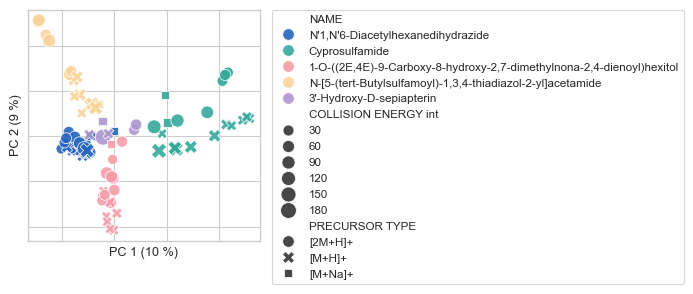

N'1,N'6-Diacetylhexanedihydrazide
258.132805
CC(=O)NNC(=O)CCCCC(=O)NNC(C)=O


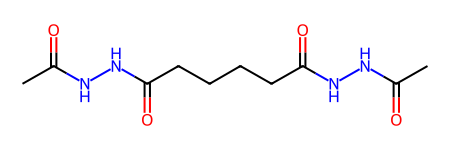

Cyprosulfamide
374.093643
COc1ccccc1C(=O)N[S@SP](=O)(=O)c1ccc(C(=O)NC2CC2)cc1


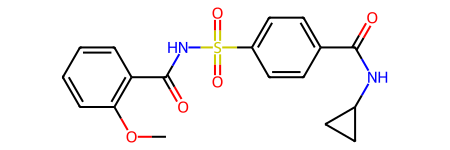

1-O-((2E,4E)-9-Carboxy-8-hydroxy-2,7-dimethylnona-2,4-dienoyl)hexitol
406.183897
C/C(=C\C=C\CC(C)C(O)CC(=O)O)C(=O)OCC(O)C(O)C(O)C(O)CO


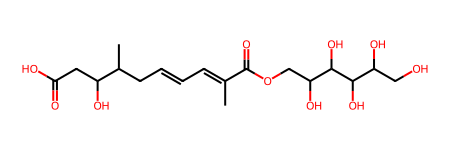

N-[5-(tert-Butylsulfamoyl)-1,3,4-thiadiazol-2-yl]acetamide
278.050732
CC(=O)Nc1nnc(S(=O)(=O)NC(C)(C)C)s1


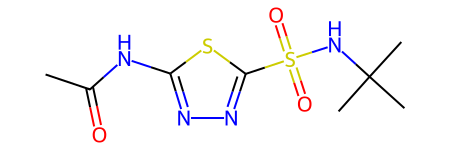

3'-Hydroxy-D-sepiapterin
253.081104
Nc1nc(=O)c2c([nH]1)NCC(C(=O)[C@H](O)CO)=N2


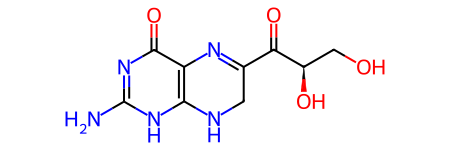

In [24]:
import umap
from rdkit import Chem
from dreams.utils.plots import get_nature_hex_colors, save_fig
colors = get_nature_hex_colors() + ['#A870B5']

i = 144

print(i)
df_adducts_subset = df_common_adducts[df_common_adducts['NAME'].isin(pd.Series(df_common_adducts['NAME'].unique()).sample(n=5, random_state=i))].sample(frac=1, random_state=4)
idx = df_adducts_subset.index.tolist()
# df_adducts_subset

df_adducts_subset['COLLISION ENERGY int'] = df_adducts_subset['COLLISION ENERGY'].apply(lambda x: int(x.split('=')[1].split('%')[0]))

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from dreams.utils.plots import init_plotting
init_plotting(figsize=(3, 3), cmap='plotly')

embs_pca = embs[idx]

embs_pca = StandardScaler().fit_transform(embs_pca)
pca = PCA(n_components=2)
embs_pca = pca.fit_transform(embs_pca)
expl_var = pca.explained_variance_ratio_
print(expl_var)

# reducer = umap.UMAP(metric='cosine', n_components=2)#, n_neighbors=3, min_dist=0.8)
# embs_pca = reducer.fit_transform(embs_pca)


sns.scatterplot(x=embs_pca[:, 0], y=embs_pca[:, 1], s=70, hue=df_adducts_subset['NAME'], alpha=0.9, style=df_adducts_subset['PRECURSOR TYPE'], palette=colors, size=df_adducts_subset['COLLISION ENERGY int'], sizes=(50, 130))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tick_params(labelleft=False, labeltop=False, labelright=False, labelbottom=False)
plt.xlabel(f'PC 1 ({round(expl_var[0] * 100)} %)')
plt.ylabel(f'PC 2 ({round(expl_var[1] * 100)} %)')
save_fig('adducts_pca.svg')
plt.show()

df_adducts_subset_u = df_adducts_subset.drop_duplicates('NAME')
for i, row in df_adducts_subset_u.iterrows():
    print(row['NAME'])
    print(row['EXACT MASS'])
    print(Chem.MolToSmiles(row['ROMol']))
    display(row['ROMol'])